K-Means_ versión1

Realizaremos un análisis de k-means no supervisado para la detección de fraude en el conjunto de datos mediante una serie de pasos. Es un conjunto enorme que incluye datos tanto categóricos como numéricos, por lo que será necesario procesarlo y transformarlo antes de poder aplicar el modelo. A continuación se muestra el procedimiento.

In [1]:
import pandas as pd
import numpy as np


# Visualización
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D

# Modelos
# ==============================================================================


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [2]:
# Cargar datos
df_fraude = pd.read_csv('fraud_test.csv', sep=",")

## 1. Análisis Exploratorio de Datos (EDA)

Cargar y Preparar el Conjunto de Datos

In [3]:
# Para facilitar nuestro dataset, se renombran las columnnas de ingles a español.
# Diccionario de mapeo de nombres en inglés a español
columnas_renombradas = {
    'trans_date_trans_time': 'fecha_transaccion',
    'cc_num': 'num_tarjeta',
    'merchant': 'comerciante',
    'category': 'categoria',
    'amt': 'monto',
    'first': 'nombre',
    'last': 'apellido',
    'gender': 'genero',
    'street': 'calle',
    'city': 'ciudad',
    'state': 'estado',
    'zip': 'codigo_postal',
    'lat': 'latitud',
    'long': 'longitud',
    'city_pop': 'poblacion_ciudad',
    'job': 'trabajo',
    'dob': 'fecha_nacimiento',
    'trans_num': 'num_transaccion',
    'unix_time': 'tiempo_unix',
    'merch_lat': 'latitud_comerciante',
    'merch_long': 'longitud_comerciante',
    'is_fraud': 'es_fraude'
}

# Renombramos las columnas
df_fraude.rename(columns=columnas_renombradas, inplace=True)

# Mostramos los nuevos nombres de las columnas
print("Columnas renombradas:", df_fraude.columns)

Columnas renombradas: Index(['Unnamed: 0', 'fecha_transaccion', 'num_tarjeta', 'comerciante',
       'categoria', 'monto', 'nombre', 'apellido', 'genero', 'calle', 'ciudad',
       'estado', 'codigo_postal', 'latitud', 'longitud', 'poblacion_ciudad',
       'trabajo', 'fecha_nacimiento', 'num_transaccion', 'tiempo_unix',
       'latitud_comerciante', 'longitud_comerciante', 'es_fraude'],
      dtype='object')


In [4]:
# Convertir la columna 'fecha_nacimiento' a tipo datetime
df_fraude['fecha_nacimiento'] = pd.to_datetime(df_fraude['fecha_nacimiento'])

# calcular la edad
df_fraude['edad'] = (2020  - df_fraude['fecha_nacimiento'].dt.year)

C:\Users\bever\AppData\Local\Temp\ipykernel_4816\3655524864.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_fraude['fecha_nacimiento'] = pd.to_datetime(df_fraude['fecha_nacimiento'])


In [5]:
df_fraude['edad'].unique()

array([52, 30, 50, 33, 65, 29, 69, 48, 47, 64, 24, 44, 43, 83, 49, 32, 28,
       23, 35, 63, 72, 90, 46, 56, 62, 25, 40, 51, 45, 59, 77, 41, 34, 26,
       91, 86, 27, 21, 38, 22, 36, 42, 31, 53, 20, 71, 82, 54, 55, 75, 37,
       16, 68, 39, 70, 17, 66, 60, 79, 58, 74, 67, 96, 57, 19, 61, 94, 73,
       84, 85, 81, 78, 15, 76, 89, 93, 80, 92, 87, 88, 18])

In [6]:
print("edad minima", df_fraude['edad'].min())
print("edad maxima", df_fraude['edad'].max())

edad minima 15
edad maxima 96


In [7]:
def aplicar_grupo_edad(edad):
    if edad <= 18:
        return 'Adolescente'
    elif edad <= 25:
        return 'Joven Adulto'
    elif edad <= 64:
        return 'Adulto'
    else:
        return 'Anciano'


df_fraude['grupo_edad'] = df_fraude['edad'].apply(aplicar_grupo_edad)
df_fraude['no_fraude']= df_fraude['es_fraude'].apply(lambda x: 1 if x == 0 else 0)

df_fraude.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            555719 non-null  int64         
 1   fecha_transaccion     555719 non-null  object        
 2   num_tarjeta           555719 non-null  float64       
 3   comerciante           555719 non-null  object        
 4   categoria             555719 non-null  object        
 5   monto                 555719 non-null  float64       
 6   nombre                555719 non-null  object        
 7   apellido              555719 non-null  object        
 8   genero                555719 non-null  object        
 9   calle                 555719 non-null  object        
 10  ciudad                555719 non-null  object        
 11  estado                555719 non-null  object        
 12  codigo_postal         555719 non-null  int64         
 13 

In [8]:
# Verificar las columnas disponibles en df_fraude
print("Columnas en df_fraude:", df_fraude.columns)

Columnas en df_fraude: Index(['Unnamed: 0', 'fecha_transaccion', 'num_tarjeta', 'comerciante',
       'categoria', 'monto', 'nombre', 'apellido', 'genero', 'calle', 'ciudad',
       'estado', 'codigo_postal', 'latitud', 'longitud', 'poblacion_ciudad',
       'trabajo', 'fecha_nacimiento', 'num_transaccion', 'tiempo_unix',
       'latitud_comerciante', 'longitud_comerciante', 'es_fraude', 'edad',
       'grupo_edad', 'no_fraude'],
      dtype='object')


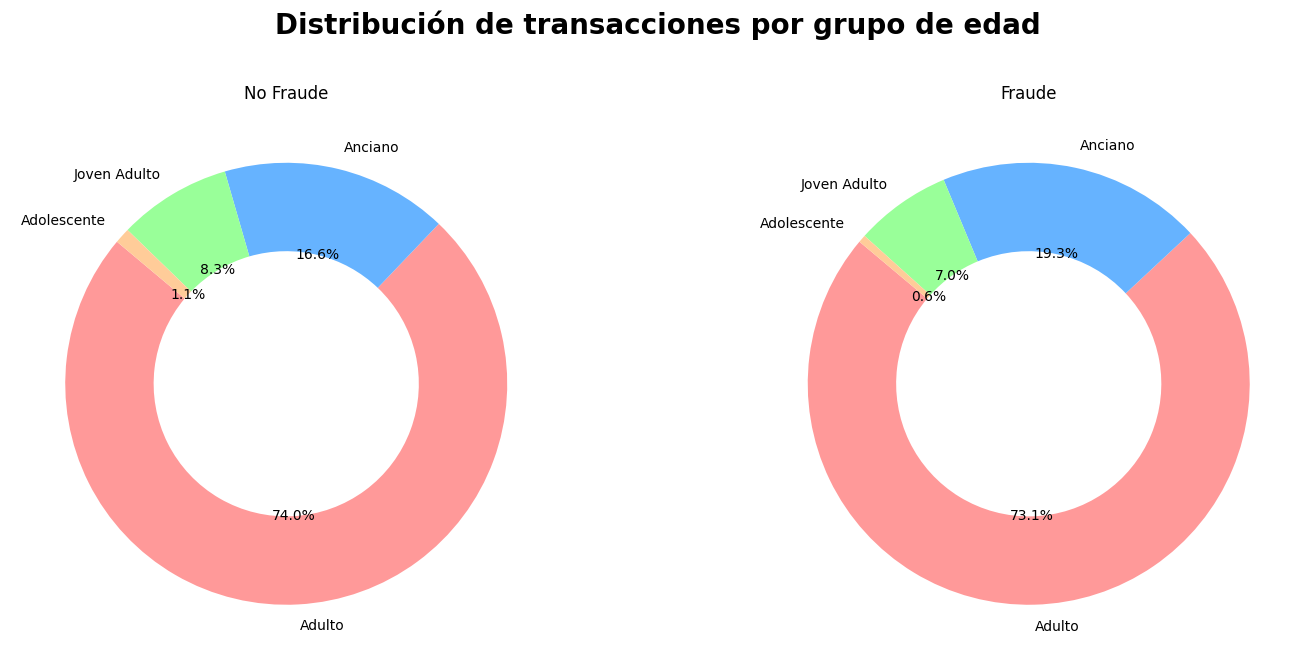

In [9]:
# transaccion por grupo de edad 
def plot_transactions_by_age_group(df_fraude):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    plt.suptitle("Distribución de transacciones por grupo de edad", fontsize=20, fontweight='bold')

    # Definir colores
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

    for i in range(2):
        df_1 = df_fraude[df_fraude['es_fraude'] == i]
        age_counts = df_1['grupo_edad'].value_counts()
        
        axs[i].pie(age_counts, labels=age_counts.index, autopct='%1.1f%%', colors=colors,
                   startangle=140, wedgeprops=dict(width=0.4))
        axs[i].set_title(["No Fraude", "Fraude"][i])

    # Ajustar el diseño
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Llamada a la función
plot_transactions_by_age_group(df_fraude)

In [10]:
df_fraude.describe()

,Unnamed: 0,num_tarjeta,monto,codigo_postal,latitud,longitud,poblacion_ciudad,fecha_nacimiento,tiempo_unix,latitud_comerciante,longitud_comerciante,es_fraude,edad,no_fraude
count,555719.000000,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,5.557190e+05,555719,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000
mean,277859.000000,4.178387e+17,69.392810,48842.628015,38.543253,-90.231325,8.822189e+04,1973-11-11 16:30:05.937173264,1.380679e+09,38.542798,-90.231380,0.003860,46.636237,0.996140
min,0.000000,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1924-10-30 00:00:00,1.371817e+09,19.027422,-166.671575,0.000000,15.000000,0.000000
25%,138929.500000,1.800430e+14,9.630000,26292.000000,34.668900,-96.798000,7.410000e+02,1962-09-27 00:00:00,1.376029e+09,34.755302,-96.905129,0.000000,33.000000,1.000000
50%,277859.000000,3.521420e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,1975-11-30 00:00:00,1.380762e+09,39.376593,-87.445204,0.000000,45.000000,1.000000
75%,416788.500000,4.635330e+15,83.010000,72011.000000,41.894800,-80.175200,1.968500e+04,1987-04-23 00:00:00,1.385867e+09,41.954163,-80.264637,0.000000,58.000000,1.000000
max,555718.000000,4.992350e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,2005-01-29 00:00:00,1.388534e+09,66.679297,-66.952026,1.000000,96.000000,1.000000
std,160422.401459,1.309837e+18,156.745941,26855.283328,5.061336,13.721780,3.003909e+05,NaN,5.201104e+06,5.095829,13.733071,0.062008,17.418528,0.062008


## 2. Aprendizaje No Supervisado k-means

Seleccionar características relevantes para el análisis K-Means y transformar datos categóricos en numéricos.

In [11]:
# Seleccionar características relevantes
caracteristicas = ['monto', 'grupo_edad', 'codigo_postal', 'poblacion_ciudad']

# Crear preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['monto']),
        ('cat', OneHotEncoder(), ['grupo_edad'])
    ])

# Aplicar preprocesamiento
X = preprocessor.fit_transform(df_fraude[caracteristicas])


In [12]:
# Aplicar el algoritmo K-Means y el método del codo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

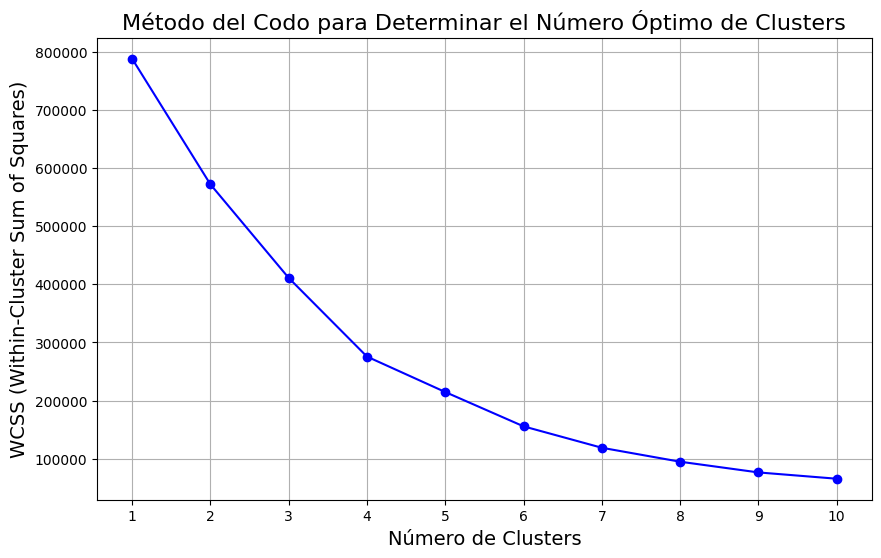

In [13]:
# Visualización del método del codo
plt.figure(figsize=(10, 6))  # Aumentar el tamaño de la figura
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')  # Agregar marcadores y color
plt.title("Método del Codo para Determinar el Número Óptimo de Clusters", fontsize=16)
plt.xlabel("Número de Clusters", fontsize=14)
plt.ylabel("WCSS (Within-Cluster Sum of Squares)", fontsize=14)
plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura
plt.xticks(range(1, 11))  # Asegurarse de que todas las etiquetas del eje x se muestren
plt.show()


In [22]:
# Ajustar K-Means con k óptimo (ejemplo con k=5)
k_optimo = 5
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df_fraude['cluster'] = kmeans.fit_predict(X)

# Ver las primeras filas con las etiquetas de clusters
print(df_fraude[['cluster']].head())


   cluster
0        0
1        0
2        0
3        0
4        1


In [17]:
print(df_fraude.groupby('cluster').size())

cluster
0    404067
1     91304
2       177
3      8391
4     51780
dtype: int64


In [18]:
# Reducir a 2D usando PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


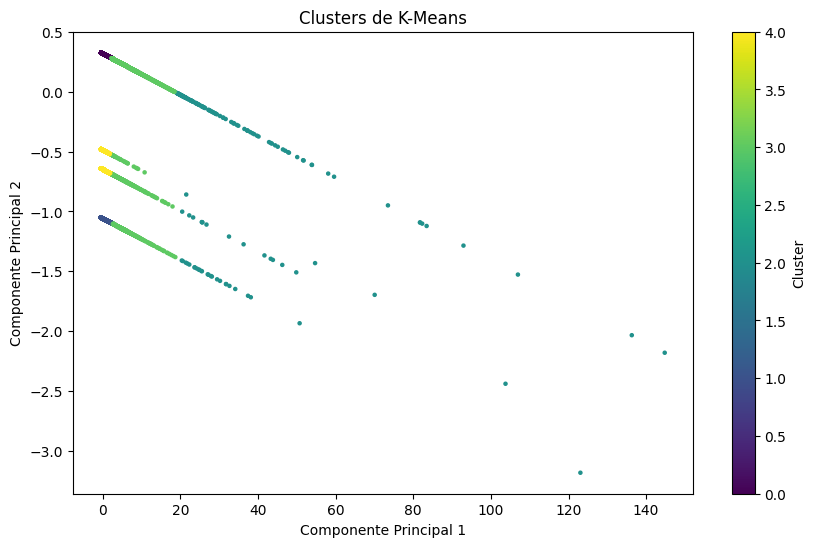

In [19]:


# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_fraude['cluster'], cmap='viridis', s=5)
plt.title('Clusters de K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()


In [20]:
# Número óptimo de clusters identificado
k_optimo = 3  # Por ejemplo, si el codo se encuentra en 3 clusters

# Aplicar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=k_optimo, init="k-means++", max_iter=300, n_init=10, random_state=0)
df_fraude['cluster'] = kmeans.fit_predict(X)

# Ver los primeros resultados con la asignación de clusters
print(df_fraude[['monto', 'grupo_edad', 'cluster']].head())


   monto grupo_edad  cluster
0   2.86     Adulto        2
1  29.84     Adulto        2
2  41.28     Adulto        2
3  60.05     Adulto        2
4   3.19    Anciano        0


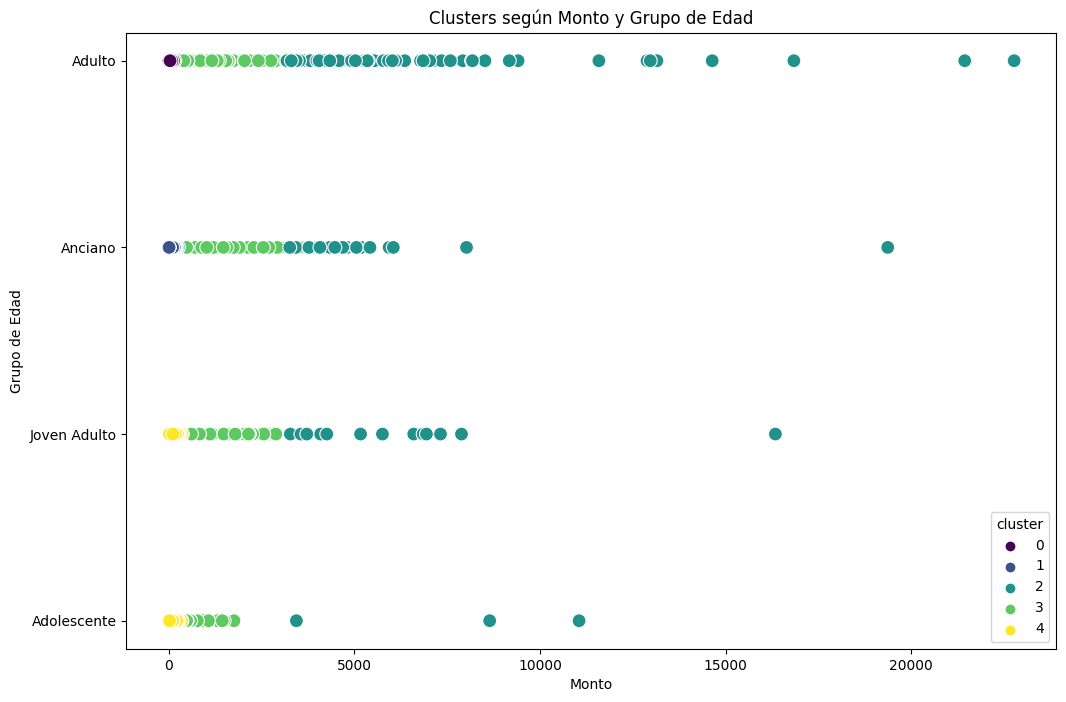

In [23]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(x='monto', y='grupo_edad', hue='cluster', data=df_fraude, palette='viridis', s=100)
plt.title("Clusters según Monto y Grupo de Edad")
plt.xlabel("Monto")
plt.ylabel("Grupo de Edad")
plt.show()


In [24]:
import numpy as np
from sklearn.metrics import silhouette_score

# Determinar el tamaño de la muestra
sample_size = int(0.1 * X.shape[0])

# Tomar una muestra aleatoria de los índices
sample_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)

# Crear la muestra usando los índices seleccionados
X_sample = X[sample_indices]
labels_sample = df_fraude['cluster'].values[sample_indices]

# Calcular el coeficiente de silueta sobre la muestra
silhouette_avg = silhouette_score(X_sample, labels_sample)
print(f"El coeficiente de silueta promedio es: {silhouette_avg:.2f}")




El coeficiente de silueta promedio es: 0.74


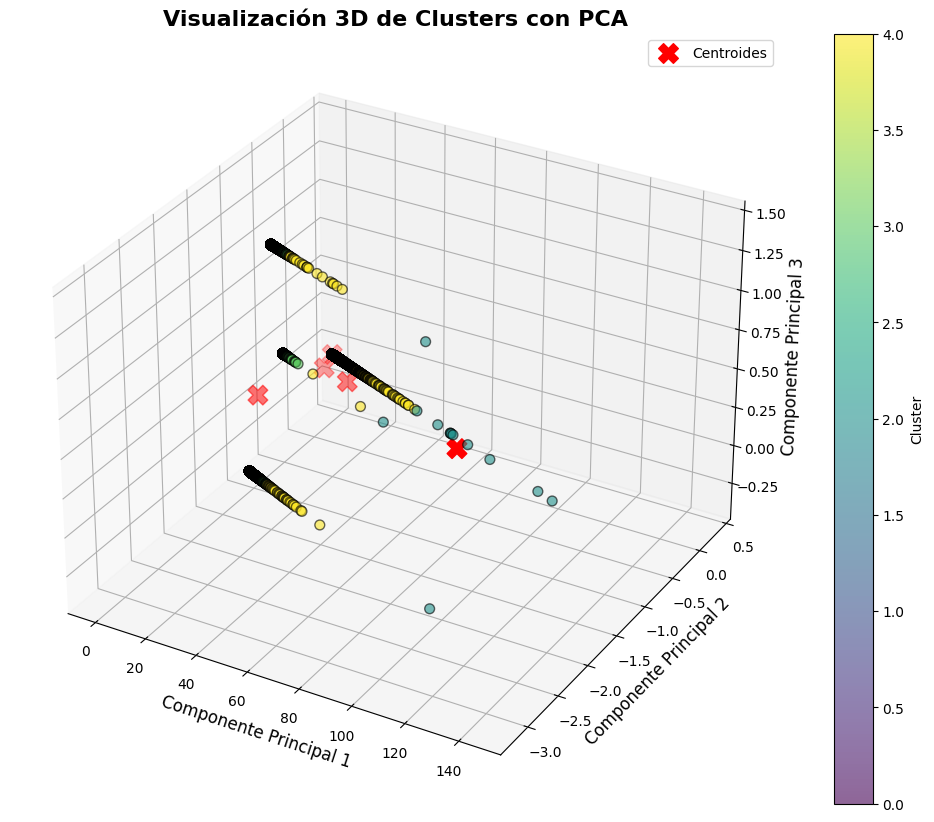

In [27]:

# Suponiendo que el número óptimo de clusters es 5 (ir probando desde 2 a 5)
optimal_k = 5

# Reducir a 3 componentes principales con PCA
pca = PCA(n_components=3)
features_pca = pca.fit_transform(X)

# Aplicar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(features_pca)
centroids = kmeans.cluster_centers_

# Visualización 3D con los centroides
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos de datos
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2],
                     c=cluster_labels, cmap='viridis', edgecolor='k', s=50, alpha=0.6)

# Graficar los centroides
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], 
           c='red', s=200, marker='X', label='Centroides')

# Añadir etiquetas y leyenda
ax.set_title('Visualización 3D de Clusters con PCA', fontsize=16, fontweight='bold')
ax.set_xlabel('Componente Principal 1', fontsize=12)
ax.set_ylabel('Componente Principal 2', fontsize=12)
ax.set_zlabel('Componente Principal 3', fontsize=12)
ax.legend()

# Añadir colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.show()



ajustar el modelo

In [28]:
# Seleccionar las características relevantes
X = df_fraude[['monto', 'grupo_edad']]

# Convertir la columna 'grupo_edad' a numérica (si no lo has hecho ya)
X['grupo_edad'] = X['grupo_edad'].map({'Adolescente': 0, 'Joven Adulto': 1, 'Adulto': 2, 'Anciano': 3})

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA para reducir a 2 componentes principales
pca = PCA(n_components=2)
features_pca = pca.fit_transform(X_scaled)


C:\Users\bever\AppData\Local\Temp\ipykernel_4816\1980082044.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['grupo_edad'] = X['grupo_edad'].map({'Adolescente': 0, 'Joven Adulto': 1, 'Adulto': 2, 'Anciano': 3})


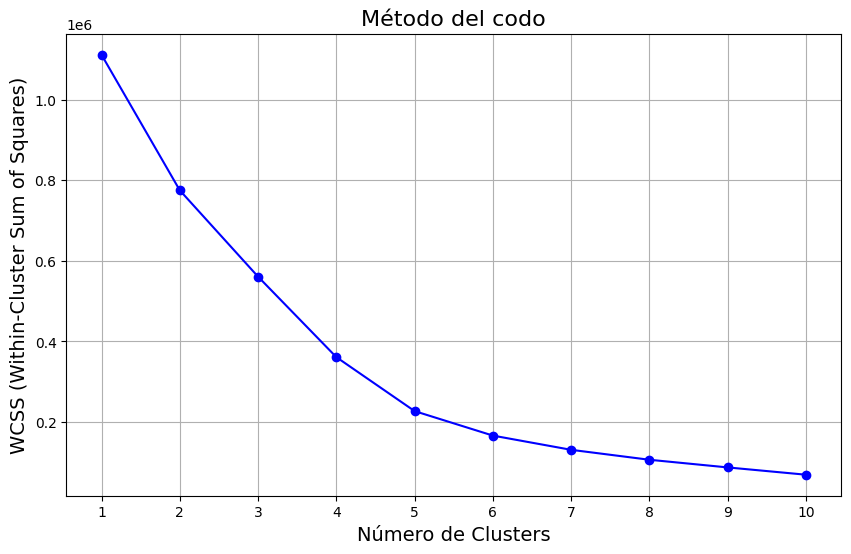

In [29]:
# Determinar el número óptimo de clusters usando el método del codo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features_pca)
    wcss.append(kmeans.inertia_)

# Visualización del método del codo
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title("Método del codo", fontsize=16)
plt.xlabel("Número de Clusters", fontsize=14)
plt.ylabel("WCSS (Within-Cluster Sum of Squares)", fontsize=14)
plt.grid(True)
plt.xticks(range(1, 11))
plt.show()

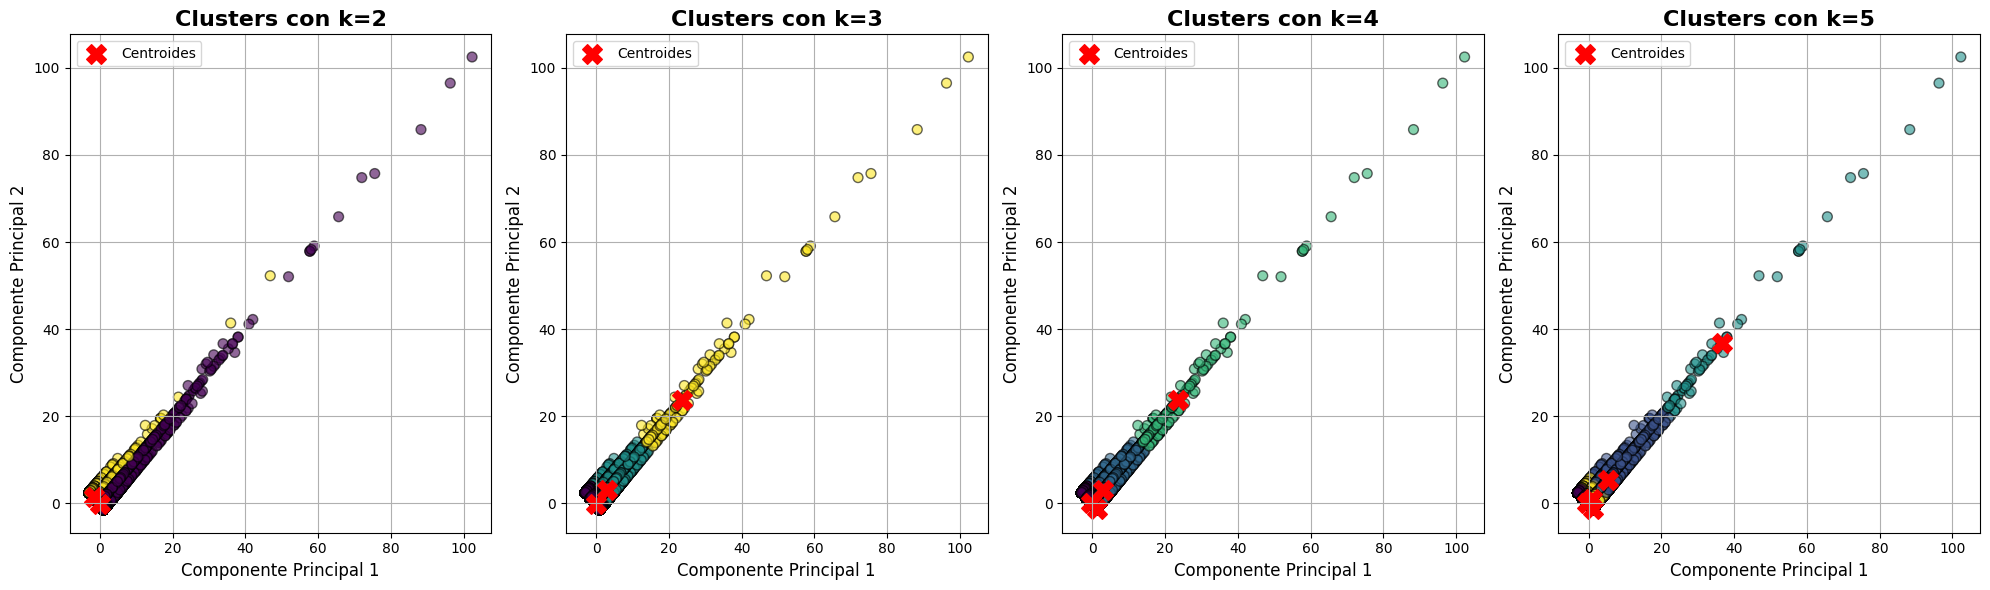

In [30]:
# Crear una lista con los valores de k que queremos comparar
k_values = [2, 3, 4, 5]

# Crear gráficos para cada valor de k
fig, axes = plt.subplots(1, len(k_values), figsize=(20, 6))

for idx, k in enumerate(k_values):
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(features_pca)
    centroids = kmeans.cluster_centers_

    # Visualización de los clusters
    ax = axes[idx]
    scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50, alpha=0.6)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroides')
    ax.set_title(f'Clusters con k={k}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Componente Principal 1', fontsize=12)
    ax.set_ylabel('Componente Principal 2', fontsize=12)
    ax.legend()
    ax.grid(True)

# Ajustar el espaciado entre los gráficos
plt.tight_layout()
plt.show()

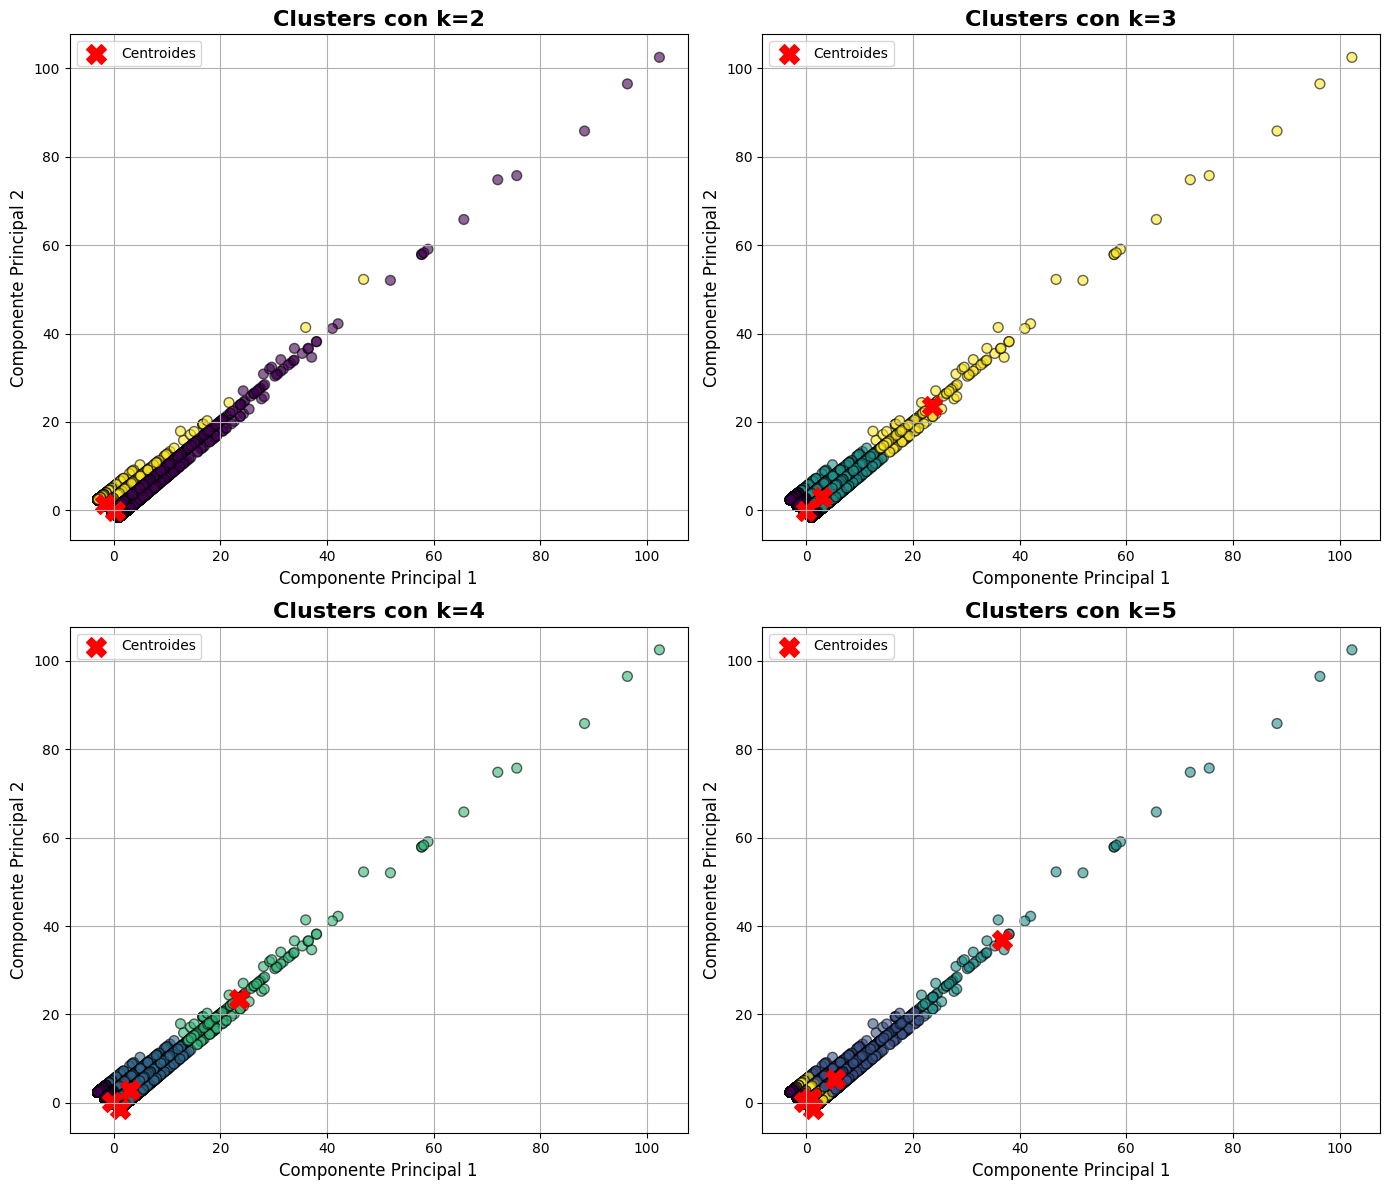

In [31]:


# Crear una lista con los valores de k que queremos comparar
k_values = [2, 3, 4, 5]

# Crear gráficos para cada valor de k en una disposición 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, k in enumerate(k_values):
    row, col = divmod(idx, 2)
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(features_pca)
    centroids = kmeans.cluster_centers_

    # Visualización de los clusters
    ax = axes[row, col]
    scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50, alpha=0.6)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroides')
    ax.set_title(f'Clusters con k={k}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Componente Principal 1', fontsize=12)
    ax.set_ylabel('Componente Principal 2', fontsize=12)
    ax.legend()
    ax.grid(True)

# Ajustar el espaciado entre los gráficos
plt.tight_layout()
plt.show()


In [32]:
# Estadísticas descriptivas de cada cluster
for cluster in range(optimal_k):
    print(f'Cluster {cluster}')
    print(df_fraude[df_fraude['cluster'] == cluster].describe())


Cluster 0
          Unnamed: 0   num_tarjeta          monto  codigo_postal  \
count  404067.000000  4.040670e+05  404067.000000  404067.000000   
mean   278132.389042  4.370772e+17      58.765575   48859.687507   
min         0.000000  6.041621e+10       1.000000    1257.000000   
25%    139092.500000  1.800180e+14      10.010000   25526.000000   
50%    278290.000000  3.518230e+15      48.170000   48174.000000   
75%    417189.500000  4.642260e+15      81.790000   72476.000000   
max    555718.000000  4.992350e+18     399.470000   99746.000000   
std    160442.053470  1.338559e+18      57.385535   27092.148096   

             latitud       longitud  poblacion_ciudad  \
count  404067.000000  404067.000000      4.040670e+05   
mean       38.370150     -90.250274      9.238252e+04   
min        20.027100    -156.292000      2.300000e+01   
25%        34.571500     -97.209200      7.650000e+02   
50%        39.150500     -87.461600      2.566000e+03   
75%        41.698300     -80.065200

In [33]:


# Ver la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
print(f'Varianza explicada por cada componente: {explained_variance}')
print(f'Varianza total explicada: {explained_variance.sum()}')


Varianza explicada por cada componente: [0.50057593 0.49942407]
Varianza total explicada: 1.0
